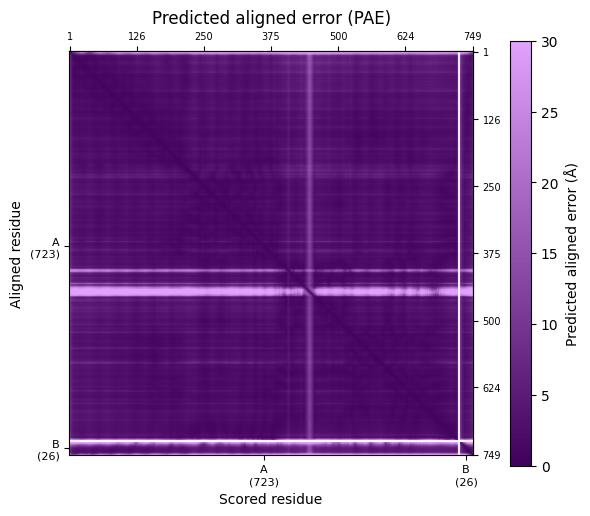

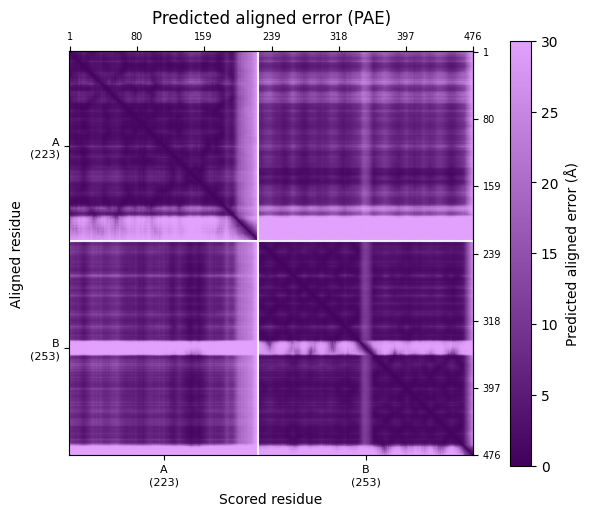

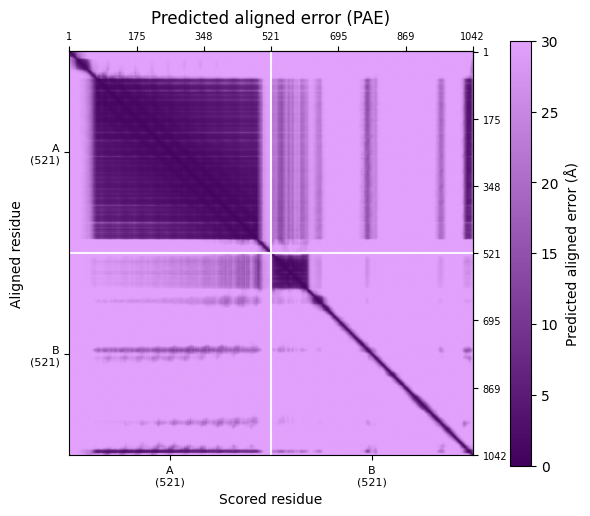

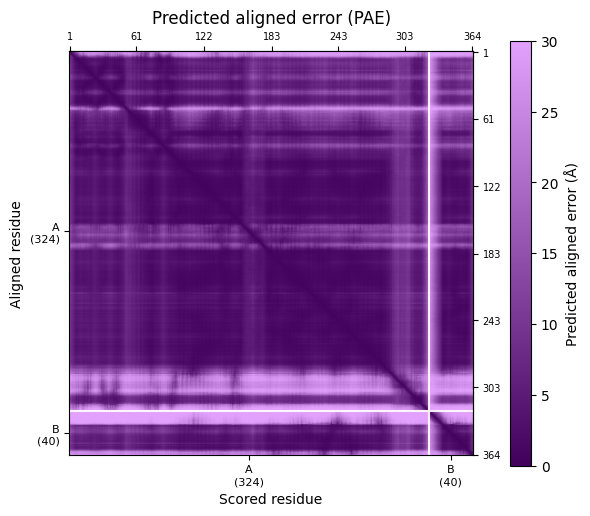

In [ ]:
"""
Plot AlphaFold3 PAE matrix in AF3 style.
Input: JSON file containing key 'pae' and optionally 'token_chain_ids'.
"""

import json
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def plot_pae(json_file, out_file="pae_plot.png"):
    # load data
    with open(json_file, "r") as f:
        data = json.load(f)

    pae = np.array(data["pae"])
    n = pae.shape[0]

    # optional chain ids (list length n) specifying chain per residue token
    chain_ids = data.get('token_chain_ids') or data.get('chain_ids')
    chain_boundaries = []  # list of (start_idx, end_idx, chain_label)
    if chain_ids and len(chain_ids) == n:
        prev = chain_ids[0]
        start = 0
        for i, cid in enumerate(chain_ids[1:], start=1):
            if cid != prev:
                chain_boundaries.append((start, i-1, prev))
                start = i
                prev = cid
        chain_boundaries.append((start, n-1, prev))
    else:
        # fallback single block
        chain_boundaries.append((0, n-1, 'Chain'))

    # Create custom colormap from dark purple to light purple
    colors = ['#41005b', '#e2a1fc']
    custom_cmap = LinearSegmentedColormap.from_list('custom_purple', colors)

    # plot
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(
        pae,
        cmap=custom_cmap,
        origin="upper",
        vmin=0,
        vmax=30
    )

    # Move colorbar slightly further right by increasing pad
    cbar = fig.colorbar(im, ax=ax, location='right', fraction=0.046, pad=0.08)
    cbar.set_label("Predicted aligned error (Å)")

    # draw chain boundaries (skip after last)
    for (s, e, lbl) in chain_boundaries[:-1]:
        pos = e + 0.5
        ax.axhline(pos, color='white', lw=1.5, alpha=0.9)
        ax.axvline(pos, color='white', lw=1.5, alpha=0.9)

    # ticks: midpoint of each chain with label + length
    xticks = []
    xlabels = []
    for (s, e, lbl) in chain_boundaries:
        mid = (s + e) / 2.0
        xticks.append(mid)
        length = e - s + 1
        xlabels.append(f'{lbl}\n({length})')

    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels, fontsize=8)
    ax.set_yticks(xticks)
    ax.set_yticklabels(xlabels, fontsize=8)

    # Global residue numbering from 1..n with exactly 7 evenly spaced ticks
    top_ax = ax.secondary_xaxis('top')
    right_ax = ax.secondary_yaxis('right')
    desired_ticks = 7
    if n <= desired_ticks:
        positions = list(range(n))
    else:
        raw = np.linspace(0, n-1, desired_ticks)
        positions = [int(round(x)) for x in raw]
        seen = set()
        uniq = []
        for p in positions:
            if p not in seen:
                uniq.append(p)
                seen.add(p)
        while len(uniq) < desired_ticks and n > desired_ticks:
            uniq = [int(x) for x in np.linspace(0, n-1, desired_ticks)]
            uniq = sorted(set(uniq))
            if len(uniq) < desired_ticks:
                for i in range(n):
                    if i not in uniq:
                        uniq.append(i)
                    if len(uniq) == desired_ticks:
                        break
                uniq.sort()
        positions = uniq
    labels = [str(p+1) for p in positions]
    top_ax.set_xticks(positions)
    top_ax.set_xticklabels(labels, fontsize=7, rotation=0)
    right_ax.set_yticks(positions)
    right_ax.set_yticklabels(labels, fontsize=7)

    ax.set_xlabel("Scored residue")
    ax.set_ylabel("Aligned residue")
    ax.set_title("Predicted aligned error (PAE)")

    plt.tight_layout()
    plt.savefig(out_file, dpi=300)
    plt.show()


# Define list of input/output file pairs
file_pairs = [
    ("/home/markus/MPI_local/HPC_results_full/production2/production2/batch_9/4n3a/4n3a/4n3a_confidences.json", 
     '/home/markus/Desktop/Thesis/4n3a_pae_plot.png'),
    ("/home/markus/MPI_local/HPC_results_full/production2/production2/batch_9/7f15/7f15/7f15_confidences.json", 
     '/home/markus/Desktop/Thesis/7f15_pae_plot.png'),
    ("/home/markus/MPI_local/data/plotting/o00629_1-521_q14814_1-521/o00629_1-521_q14814_1-521/o00629_1-521_q14814_1-521_confidences.json", 
     '/home/markus/Desktop/Thesis/o00629_1-521_q14814_1-521_pae_plot.png'),
    ("/home/markus/MPI_local/data/plotting/2rfe_a_e_confidences.json", 
     '/home/markus/Desktop/Thesis/2rfe_pae_plot.png'),

    ("/home/markus/MPI_local//plotting/2rfe_a_e_confidences.json", 
     '/home/markus/Desktop/Thesis/2rfe_pae_plot.png'),
    ("/home/markus/MPI_local/data/plotting/2rfe_a_e_confidences.json", 
     '/home/markus/Desktop/Thesis/2rfe_pae_plot.png'),
    ("/home/markus/MPI_local/data/plotting/2rfe_a_e_confidences.json", 
     '/home/markus/Desktop/Thesis/2rfe_pae_plot.png')
]

# Generate all plots
for infile, outfile in file_pairs:
    plot_pae(infile, outfile)